# Segementation for Intracranial Haemorrhage Detection

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
plt.style.use("ggplot")
%matplotlib inline

Using TensorFlow backend.


## Process data

In [2]:
base_length, height = 128, 128
root_path = '/home/imhs/data_ICH/image'
list_image_files = [image_files for image_files in os.listdir(root_path) if os.path.isfile(os.path.join(root_path, image_files))]
total_image_files = len(list_image_files)

print("Images to be processed: ", total_image_files)

Images to be processed:  2814


In [3]:
training_images = np.zeros((total_image_files, height, base_length, 1), dtype=np.float32)
labels = np.zeros((total_image_files, height, base_length, 1), dtype=np.float32)

In [4]:
image_dict = {}
for num, image_id in tqdm_notebook(enumerate(list_image_files), total=total_image_files):
    image_dict[num] = image_id

/home/imhs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [5]:
for num, image_id in tqdm_notebook(enumerate(list_image_files), total=total_image_files):
    image_file = load_img("data_ICH/image/" + image_id, grayscale=True)
    image_array = img_to_array(image_file)
    image_array = resize(image_array, (base_length, height, 1), mode = 'constant', preserve_range = True)
    label_file = load_img("data_ICH/label/" + image_id, grayscale=True)
    label_array = img_to_array(label_file)
    label_array = resize(label_array, (base_length, height, 1), mode = 'constant', preserve_range = True)
    training_images[num] = image_array/255.0
    labels[num] = label_array/255.0

/home/imhs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/home/imhs/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


## Split data into train and test sets

In [6]:
X_train, X_valid, Y_train, Y_valid = train_test_split(training_images, labels, test_size=0.1, shuffle=False)

## Create Model

In [7]:
def convolutional_layer(image_input, image_filters, image_kernel_size = 3):
    inputs = Conv2D(filters = image_filters, kernel_size = (image_kernel_size, image_kernel_size),kernel_initializer = 'he_normal', padding = 'same')(image_input)
    inputs = BatchNormalization()(inputs)
    inputs = Activation('relu')(inputs)
    
    inputs = Conv2D(filters = image_filters, kernel_size = (image_kernel_size, image_kernel_size),kernel_initializer = 'he_normal', padding = 'same')(image_input)
    inputs = BatchNormalization()(inputs)
    inputs = Activation('relu')(inputs)
    
    return inputs

In [8]:
def unet_model(image_input, image_filters = 16, dropout = 0.1):
    """Function to define the UNET Model"""
    # Contracting Path
    conv1 = convolutional_layer(image_input, image_filters * 1, image_kernel_size = 3)
    pool1 = MaxPooling2D((2, 2))(conv1)
    drop1 = Dropout(dropout)(pool1)
    
    conv2 = convolutional_layer(pool1, image_filters * 2, image_kernel_size = 3)
    pool2 = MaxPooling2D((2, 2))(conv2)
    drop2 = Dropout(dropout)(pool2)
    
    conv3 = convolutional_layer(pool2, image_filters * 4, image_kernel_size = 3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    drop3 = Dropout(dropout)(pool3)
    
    conv4 = convolutional_layer(pool3, image_filters * 8, image_kernel_size = 3)
    pool4 = MaxPooling2D((2, 2))(conv4)
    drop4 = Dropout(dropout)(pool4)
    
    conv5 = convolutional_layer(pool4, image_filters * 16, image_kernel_size = 3)
    
    trans6 = Conv2DTranspose(image_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(conv5)
    trans6 = concatenate([trans6, conv4])
    trans6 = Dropout(dropout)(trans6)
    conv6 = convolutional_layer(trans6, image_filters * 8, image_kernel_size = 3)
    
    trans7 = Conv2DTranspose(image_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(conv6)
    trans7 = concatenate([trans7, conv3])
    trans7 = Dropout(dropout)(trans7)
    conv7 = convolutional_layer(trans7, image_filters * 4, image_kernel_size = 3)
    
    trans8 = Conv2DTranspose(image_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(conv7)
    trans8 = concatenate([trans8, conv2])
    trans8 = Dropout(dropout)(trans8)
    conv8 = convolutional_layer(trans8, image_filters * 2, image_kernel_size = 3)
    
    trans9 = Conv2DTranspose(image_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(conv8)
    trans9 = concatenate([trans9, conv1])
    trans9 = Dropout(dropout)(trans9)
    conv9 = convolutional_layer(trans9, image_filters * 1, image_kernel_size = 3)
    
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    
    model = Model(inputs=[image_input], outputs=[conv10])
    return model

In [9]:
images = Input((height, base_length, 1), name='image_file')
model = unet_model(images, image_filters=16, dropout=0.05)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [10]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_file (InputLayer)         (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 160         image_file[0][0]                 
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 128, 128, 16) 64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 128, 128, 16) 0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

In [11]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('unet-model-weights.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

## Train Model

In [12]:
results = model.fit(X_train, Y_train, batch_size=32, epochs=50, callbacks=callbacks,validation_data=(X_valid, Y_valid))

Train on 2532 samples, validate on 282 samples
Epoch 1/50
2532/2532 [==============================] - 106s 42ms/step - loss: 0.2913 - accuracy: 0.9850 - val_loss: 0.2942 - val_accuracy: 0.9983

Epoch 00001: val_loss improved from inf to 0.29416, saving model to unet-model-weights.h5
Epoch 2/50
2532/2532 [==============================] - 82s 33ms/step - loss: 0.1292 - accuracy: 0.9979 - val_loss: 0.1142 - val_accuracy: 0.9990

Epoch 00002: val_loss improved from 0.29416 to 0.11417, saving model to unet-model-weights.h5
Epoch 3/50
2532/2532 [==============================] - 81s 32ms/step - loss: 0.0752 - accuracy: 0.9981 - val_loss: 0.0560 - val_accuracy: 0.9990

Epoch 00003: val_loss improved from 0.11417 to 0.05602, saving model to unet-model-weights.h5
Epoch 4/50
2532/2532 [==============================] - 81s 32ms/step - loss: 0.0473 - accuracy: 0.9981 - val_loss: 0.0346 - val_accuracy: 0.9990

Epoch 00004: val_loss improved from 0.05602 to 0.03457, saving model to unet-model-wei

2532/2532 [==============================] - 79s 31ms/step - loss: 0.0012 - accuracy: 0.9984 - val_loss: 0.0014 - val_accuracy: 0.9990

Epoch 00036: val_loss improved from 0.00146 to 0.00142, saving model to unet-model-weights.h5
Epoch 37/50
2532/2532 [==============================] - 81s 32ms/step - loss: 0.0012 - accuracy: 0.9984 - val_loss: 0.0015 - val_accuracy: 0.9990

Epoch 00037: val_loss did not improve from 0.00142
Epoch 38/50
2532/2532 [==============================] - 81s 32ms/step - loss: 0.0011 - accuracy: 0.9984 - val_loss: 0.0013 - val_accuracy: 0.9990

Epoch 00038: val_loss improved from 0.00142 to 0.00131, saving model to unet-model-weights.h5
Epoch 39/50
2532/2532 [==============================] - 81s 32ms/step - loss: 0.0010 - accuracy: 0.9984 - val_loss: 0.0016 - val_accuracy: 0.9989

Epoch 00039: val_loss did not improve from 0.00131
Epoch 40/50
2532/2532 [==============================] - 80s 32ms/step - loss: 0.0011 - accuracy: 0.9984 - val_loss: 0.0014 - val_

In [13]:
model.load_weights('unet-model-weights.h5')

In [15]:
model.evaluate(X_valid, Y_valid, verbose=1)

282/282 [==============================] - 2s 6ms/step


[0.0012814974311593894, 0.9989678263664246]

In [16]:
training_predicted_values = model.predict(X_train, verbose=1)
validation_predicted_values = model.predict(X_valid, verbose=1)
limit_train_predict_values = (training_predicted_values > 0.5).astype(np.uint8)
limit_val_predict_values = (validation_predicted_values > 0.5).astype(np.uint8)

282/282 [==============================] - 2s 6ms/step


## Plot results

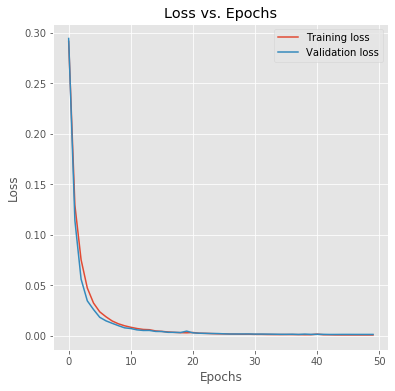

In [14]:
plt.figure(figsize=(6, 6))
plt.title("Loss vs. Epochs")
plt.plot(results.history["loss"], label="Training loss")
plt.plot(results.history["val_loss"], label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

In [17]:
def get_masked_image(actual_image, label, predicted_image, image_to_be_plotted=None):
    
    mask_list = []
    for i in range(0, len(actual_image)):
        image_mask = label[i].max() > 0
        if image_mask:
            mask_list.append(i)
    print(mask_list)

In [1]:
get_masked_image(X_train, Y_train, training_predicted_values)

In [19]:
def get_image_file_name(image_id):
    for key, value in image_dict.items():
        if key == image_id:
            return value

In [20]:
def result_image_plot(actual_image, label, predicted_image, image_to_be_plotted=None):
    image_mask = label[image_to_be_plotted].max() > 0
    if image_to_be_plotted is None:
        image_to_be_plotted = random.randint(0, len(actual_image))
        
    file_name = get_image_file_name(image_to_be_plotted)
    plot_image = load_img("data_ICH/image/" + file_name)
    f = plt.figure(figsize=(20, 20))
    
    f.add_subplot(1,4,1)
    plt.imshow(plot_image)
    plt.title('Original Image')
    
    f.add_subplot(1,4,2)
    plt.imshow(actual_image[image_to_be_plotted, ..., 0])
    plt.contour(label[image_to_be_plotted].squeeze(), levels=[0.5], colors='blue', linestyles='dashed', linewidths=2)
    plt.title('Original Image with Mask')
    
    
    f.add_subplot(1,4,3)
    plt.imshow(label[image_to_be_plotted].squeeze())
    plt.title('Label')
    
    f.add_subplot(1,4,4)
    plt.imshow(predicted_image[image_to_be_plotted].squeeze(), vmin=0, vmax=1)
    plt.contour(label[image_to_be_plotted].squeeze(), levels=[0.5], colors='red', linestyles='dashed', linewidths=2)
    plt.title('Predicted Image')

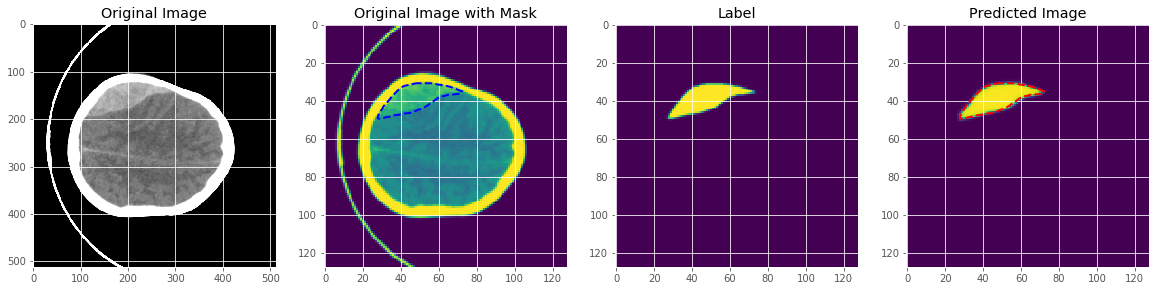

In [29]:
result_image_plot(X_train, Y_train, training_predicted_values, image_to_be_plotted=121)

In [35]:
def result_image_plot_test(actual_image, label, predicted_image, image_to_be_plotted=None):
    image_mask = label[image_to_be_plotted].max() > 0
    if image_to_be_plotted is None:
        image_to_be_plotted = random.randint(0, len(actual_image))
    
    plot_image = load_img("data_ICH/image/1318.png")
    f = plt.figure(figsize=(20, 20))
    
    f.add_subplot(1,4,1)
    plt.imshow(plot_image)
    plt.title('Original Image')
    
    f.add_subplot(1,4,2)
    plt.imshow(actual_image[image_to_be_plotted, ..., 0])
    plt.contour(label[image_to_be_plotted].squeeze(), levels=[0.5], colors='blue', linestyles='dashed', linewidths=2)
    plt.title('Original Image with Mask')
    
    
    f.add_subplot(1,4,3)
    plt.imshow(label[image_to_be_plotted].squeeze())
    plt.title('Label')
    
    f.add_subplot(1,4,4)
    plt.imshow(predicted_image[image_to_be_plotted].squeeze(), vmin=0, vmax=1)
    plt.contour(label[image_to_be_plotted].squeeze(), levels=[0.5], colors='red', linestyles='dashed', linewidths=2)
    plt.title('Predicted Image')

In [2]:
get_masked_image(X_valid, y_valid, validation_predicted_values)

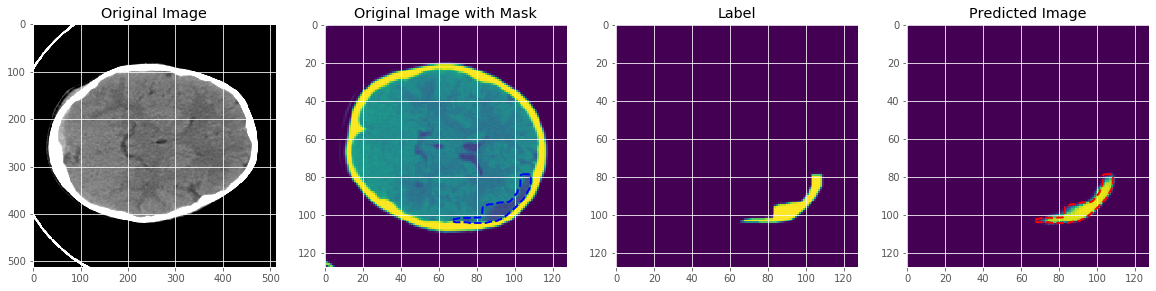

In [39]:
result_image_plot_test(X_valid, y_valid, validation_predicted_values, image_to_be_plotted=198)